# ML for Match Prediction

Comparing different algorithms for match prediction based on network metric timeseries results.

Yuval Berman.

In [1]:
# Import necessary libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import pyts
import matplotlib.pyplot as plt

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

In [3]:
os.chdir('/Users/Yuval/Desktop/Pawsey/data/')

In [4]:

## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

# allDone()

### Data Cleaning

In [5]:
def append_dfs(directory):
    df = pd.DataFrame()
    files = os.listdir(directory)

    for file in files:
        if '.json' in file:
            df2 = pd.read_json(directory+file)
            df = df.append(df2,ignore_index=True,sort = False)
    
    return df

In [6]:
Matches_df = append_dfs('matches/')
ent_df = append_dfs('revised_entropy_df/')
bet_df = append_dfs('betweenness_df/')
clo_df = append_dfs('closeness_df/')
outdeg_df = append_dfs('outdegree_df/')
clu_df = append_dfs('clustering_df/')
eve_df = append_dfs('eigenvector_std_df/')

In [7]:
# Remove nan rows
ent_df = ent_df.loc[np.isnan(ent_df['5.0'])==False]
ent_df
# Great! It has no nans

,teamId,Opponent,matchId,5.0,5.5,6.0,6.5,7.0,7.5,8.0,...,80.0,80.5,81.0,81.5,82.0,82.5,83.0,83.5,84.0,84.5
0,2446,2975,2516992,0.317546,0.316996,0.336427,0.357042,0.361491,0.357391,0.366039,...,0.400317,0.371050,0.339643,0.364728,0.389646,0.395021,0.395021,0.393800,0.393800,0.394883
1,2975,2446,2516992,0.490199,0.461628,0.477921,0.385478,0.360352,0.385438,0.385438,...,0.328196,0.301193,0.355941,0.371949,0.371949,0.371949,0.418589,0.350184,0.420143,0.351905
2,2460,2463,2516993,0.308547,0.308547,0.268868,0.332014,0.334145,0.373582,0.316275,...,0.069468,0.185249,0.220059,0.256761,0.256761,0.233604,0.253071,0.248712,0.205337,0.205337
3,2463,2460,2516993,0.249063,0.223977,0.249063,0.249063,0.249063,0.249063,0.280461,...,0.064163,0.082495,0.082495,0.082495,0.111791,0.203111,0.203111,0.196770,0.249073,0.249073
4,2451,2453,2516994,0.298427,0.313101,0.234298,0.194538,0.244240,0.262395,0.230888,...,0.086009,0.086461,0.086461,0.086461,0.097269,0.097269,0.097269,0.053013,0.053013,0.077815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,3158,3315,2576336,0.422499,0.395401,0.389270,0.408700,0.404211,0.415933,0.415933,...,0.461202,0.467575,0.467575,0.440314,0.447321,0.447321,0.439627,0.423764,0.417113,0.417113
3878,3204,3164,2576337,0.280207,0.207081,0.150655,0.164473,0.148856,0.148856,0.148856,...,0.242397,0.334456,0.323801,0.271205,0.238193,0.238193,0.238193,0.244791,0.255203,0.291745
3879,3164,3204,2576337,0.350385,0.339027,0.335646,0.344456,0.344456,0.345593,0.345593,...,0.230155,0.221345,0.219209,0.267270,0.359736,0.314963,0.339691,0.339691,0.347767,0.358342
3880,3193,3185,2576338,0.452872,0.430230,0.430230,0.453801,0.453801,0.478009,0.475754,...,0.404759,0.434387,0.410969,0.412583,0.412583,0.392965,0.341150,0.357759,0.373767,0.373767


In [8]:
matches = list(Matches_df['wyId'])

In [9]:
def score_getter(Matches,match,team):
    
    Matches = Matches.loc[Matches['wyId'] == match]
    label = list(Matches['teamsData'])[0]
    
    if len(list(Matches['teamsData']))>1:
        print('Error!')
        
    teams = list(label.keys())
    
    if str(team) == teams[0]:
        sco1 = label[teams[0]]['score']
        sco2 = label[teams[1]]['score']
        return [match, int(teams[0]), int(teams[1]), sco1, sco2]
    elif str(team) == teams[1]:
        sco1 = label[teams[1]]['score']
        sco2 = label[teams[0]]['score']
        return [match, int(teams[1]), int(teams[0]), sco1, sco2]
    else:
        print('Problem!')

In [10]:
df_list = [ent_df, bet_df,clo_df, outdeg_df, clu_df, eve_df]

In [11]:
all_diffs = []
for match in matches:
    diff = []
    for df in df_list:
        df = df.loc[df['matchId'] == match]
        #indexes = list(df.index)
        diff.append(list(df.iloc[0][3:]-df.iloc[1][3:]))
    score = score_getter(Matches_df,match,int(df.iloc[0][0]))
    diff.append(score)
    all_diffs.append(diff)

In [12]:
# Make dataframe
df = pd.DataFrame()
names = ['entropy','betweenness','closeness','outdegree','clustering','evector_std','identifier']
df = pd.DataFrame(all_diffs)
df.columns = names

In [13]:
outlabel =[]
for item in list(df['identifier']):
    out = np.sign(item[3]-item[4])
    outlabel.append(out)
    
df['outcome_label'] = outlabel

In [14]:
nanlist = []
l = np.isnan(list(df['entropy']))
for i in range(len(l)):
    for j in range(len(l[i])):
        if l[i][j] == True:
            #print(i,j)
            nanlist.append(i)
set(nanlist)

{465, 520, 622}

In [15]:
df = df.drop(list(set(nanlist)))

In [16]:
#df = df.drop([465,520,622])

### Setting aside a test set

In [17]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [18]:
train_set, test_set = split_train_test(df, 0.2)

print(len(train_set),len(test_set))

1551 387


In [32]:
X_train.shape

(1551, 6, 160)

### Creating X_train, X_test, y_train, y_test

In [19]:
from pyts.multivariate.classification import MultivariateClassifier
from pyts.classification import TimeSeriesForest
from sklearn.pipeline import Pipeline
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.compose import ColumnConcatenator
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import Rocket

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [20]:
y_train = np.array(list(train_set['outcome_label']))
y_test = np.array(list(test_set['outcome_label']))

In [23]:
X_train = []
t = 160
for index, row in train_set.iterrows():
    X_train.append([row['entropy'][:t], row['betweenness'][:t], row['closeness'][:t], row['outdegree'][:t],row['clustering'][:t], row['evector_std'][:t]])

X_train = np.array(X_train)

In [24]:
X_test = []
for index, row in test_set.iterrows():
    X_test.append([row['entropy'][:t], row['betweenness'][:t], row['closeness'][:t], row['outdegree'][:t],row['clustering'][:t], row['evector_std'][:t]])

X_test = np.array(X_test)

## Time Series Forest

In [75]:
model = MultivariateClassifier(TimeSeriesForest(n_estimators = 5000, n_windows = 100))

In [76]:
model.fit(X_train,y_train)

MultivariateClassifier(estimator=TimeSeriesForest(n_estimators=5000,
                                                  n_windows=100))

In [77]:
model.score(X_test, y_test)

0.5529715762273901

# SKtime
Multivariate time series classification with sktime

In [31]:
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
clf = Pipeline(steps)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5503875968992248

In [79]:
import time

In [80]:
# Column ensemble
t = time.time()
clf = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=100), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5), [3]),
    ]
)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
e = time.time()
print(e-t)

KeyboardInterrupt: 

In [82]:
from sktime.classification.shapelet_based import MrSEQLClassifier

In [ ]:
# Bespoke
ts = time.time()
clf = MrSEQLClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
es = time.time()
print(es-ts)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Call to deprecated class MrSEQLClassifier. (MrSEQLClassifier will be removed in v0.10.0. It will be replaced with an implementation based on Numba.) -- Deprecated since version 0.8.1.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Call to deprecated class SEQLCLF. (SEQLCLF will be removed in v0.10.0) -- Deprecated since version 0.8.1.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
allDone()

## ROCKET

In [34]:
rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

In [35]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [36]:
X_test_transform = rocket.transform(X_test)

In [37]:
classifier.score(X_test_transform, y_test)

0.5038759689922481

In [39]:
allDone()

## During Match Predictions

In [25]:
matchtimes = [20,30,40,50,60,70,80,90]
time = [(t-10)*2 for t in matchtimes]

In [26]:
time

[20, 40, 60, 80, 100, 120, 140, 160]

In [27]:
tsf = []
skt = []
roc = []
for t in time:
    X_train = []
    for index, row in train_set.iterrows():
        X_train.append([row['entropy'][:t], row['betweenness'][:t], row['closeness'][:t], row['outdegree'][:t],row['clustering'][:t], row['evector_std'][:t]])

    X_train = np.array(X_train)
    
    X_test = []
    for index, row in test_set.iterrows():
        X_test.append([row['entropy'][:t], row['betweenness'][:t], row['closeness'][:t], row['outdegree'][:t],row['clustering'][:t], row['evector_std'][:t]])

    X_test = np.array(X_test)
    
    # TSF
    model = MultivariateClassifier(TimeSeriesForest(n_estimators = 5000, n_windows = 100))
    model.fit(X_train,y_train)
    tsf.append(model.score(X_test, y_test))
    
    # column concatenator with sktime
    steps = [
        ("concatenate", ColumnConcatenator()),
        ("classify", TimeSeriesForestClassifier(n_estimators=100)),
    ]
    clf = Pipeline(steps)
    clf.fit(X_train, y_train)
    skt.append(clf.score(X_test, y_test))
    
    #Rocket
    rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
    rocket.fit(X_train)
    X_train_transform = rocket.transform(X_train)
    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(X_train_transform, y_train)
    X_test_transform = rocket.transform(X_test)
    roc.append(classifier.score(X_test_transform, y_test))
    
    


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_p

In [28]:
print(tsf,skt,roc)

[0.43669250645994834, 0.4625322997416021, 0.49870801033591733, 0.4909560723514212, 0.48320413436692505, 0.48320413436692505, 0.49870801033591733, 0.5478036175710594] [0.43410852713178294, 0.46511627906976744, 0.4470284237726098, 0.5012919896640827, 0.4754521963824289, 0.4935400516795866, 0.5090439276485789, 0.5348837209302325] [0.4186046511627907, 0.37209302325581395, 0.4134366925064599, 0.4289405684754522, 0.4444444444444444, 0.4728682170542636, 0.4599483204134367, 0.49870801033591733]


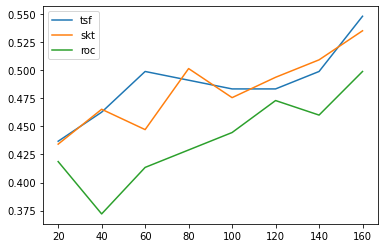

In [29]:
plt.plot(time,tsf,label = 'tsf')
plt.plot(time,skt,label = 'skt')
plt.plot(time,roc,label = 'roc')
plt.legend()

In [30]:
allDone()

In [33]:
print(tsf)

[0.43669250645994834, 0.4625322997416021, 0.49870801033591733, 0.4909560723514212, 0.48320413436692505, 0.48320413436692505, 0.49870801033591733, 0.5478036175710594]


In [34]:
print(skt)

[0.43410852713178294, 0.46511627906976744, 0.4470284237726098, 0.5012919896640827, 0.4754521963824289, 0.4935400516795866, 0.5090439276485789, 0.5348837209302325]


In [35]:
print(roc)

[0.4186046511627907, 0.37209302325581395, 0.4134366925064599, 0.4289405684754522, 0.4444444444444444, 0.4728682170542636, 0.4599483204134367, 0.49870801033591733]
